<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>NASA Climate Spiral</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from matplotlib import animation, rc

from IPython.display import HTML

import tqdm as tq
from tqdm import tqdm

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 8c8cad2fbde27aba0d3b05964d7ce781c3b552ab

matplotlib: 3.3.2
watermark : 2.1.0
pandas    : 1.1.3
tqdm      : 4.62.0
json      : 2.0.9
numpy     : 1.19.2



# Preprocess data

URL source of the data

In [3]:
url = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"

Load the data directly from the URL

In [4]:
data = pd.read_csv(url, skiprows=1, dtype='str', na_values='***')

Data has a month per column and a year per row

In [5]:
data

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-.17,-.23,-.08,-.15,-.09,-.20,-.16,-.08,-.13,-.22,-.19,-.16,-.15,NaN,NaN,-.10,-.15,-.18
1,1881,-.18,-.13,.04,.06,.07,-.17,.02,-.02,-.14,-.21,-.17,-.06,-.07,-.08,-.16,.06,-.06,-.17
2,1882,.17,.15,.05,-.16,-.13,-.22,-.15,-.06,-.13,-.23,-.15,-.36,-.10,-.08,.09,-.08,-.15,-.17
3,1883,-.28,-.36,-.12,-.18,-.17,-.06,-.06,-.13,-.21,-.11,-.23,-.11,-.17,-.19,-.33,-.15,-.09,-.19
4,1884,-.12,-.07,-.36,-.39,-.33,-.34,-.32,-.27,-.26,-.24,-.33,-.30,-.28,-.26,-.10,-.36,-.31,-.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2018,.81,.85,.89,.88,.83,.78,.83,.77,.80,1.02,.83,.92,.85,.85,.87,.87,.79,.88
139,2019,.93,.95,1.18,1.01,.85,.91,.94,.95,.92,1.01,.99,1.09,.98,.96,.93,1.01,.93,.98
140,2020,1.16,1.24,1.17,1.13,1.02,.92,.91,.87,.99,.89,1.11,.82,1.02,1.04,1.17,1.11,.90,1.00
141,2021,.82,.65,.89,.76,.79,.85,.93,.81,.92,.99,.93,.86,.85,.85,.76,.81,.86,.95


Melt the data so that each month/year value has its own row

In [6]:
data_long = pd.melt(data[data.columns[:13]], id_vars=['Year'], 
                    value_name='Temp', var_name='Month')
data_long.index = data_long[
    ['Year', "Month"]
].apply(lambda x: pd.to_datetime("%s-%s" % (x.Year, x.Month)), axis=1)

data_long.Temp = data_long.Temp.astype('float')

data_long.sort_index(inplace=True)

Compute the angle for each point. Each month gets a slice of $2\pi/12$ degrees

In [7]:
data_long['angle'] = (data_long.index.month-1)/12*2*np.pi

In [8]:
data_long.head()

,Year,Month,Temp,angle
1880-01-01,1880,Jan,-0.17,0.000000
1880-02-01,1880,Feb,-0.23,0.523599
1880-03-01,1880,Mar,-0.08,1.047198
1880-04-01,1880,Apr,-0.15,1.570796
1880-05-01,1880,May,-0.09,2.094395


Create an array associating each temperature value with the corresponding angle

In [9]:
points = np.array([data_long.angle, data_long.Temp]).T.reshape(-1, 1, 2)

Reshuffle the data to generate individual line segments that we can color separately.

In [10]:
segments = np.concatenate([points[:-1], points[1:]], axis=1)

Month names

In [11]:
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec']

Generate the first version of the figure

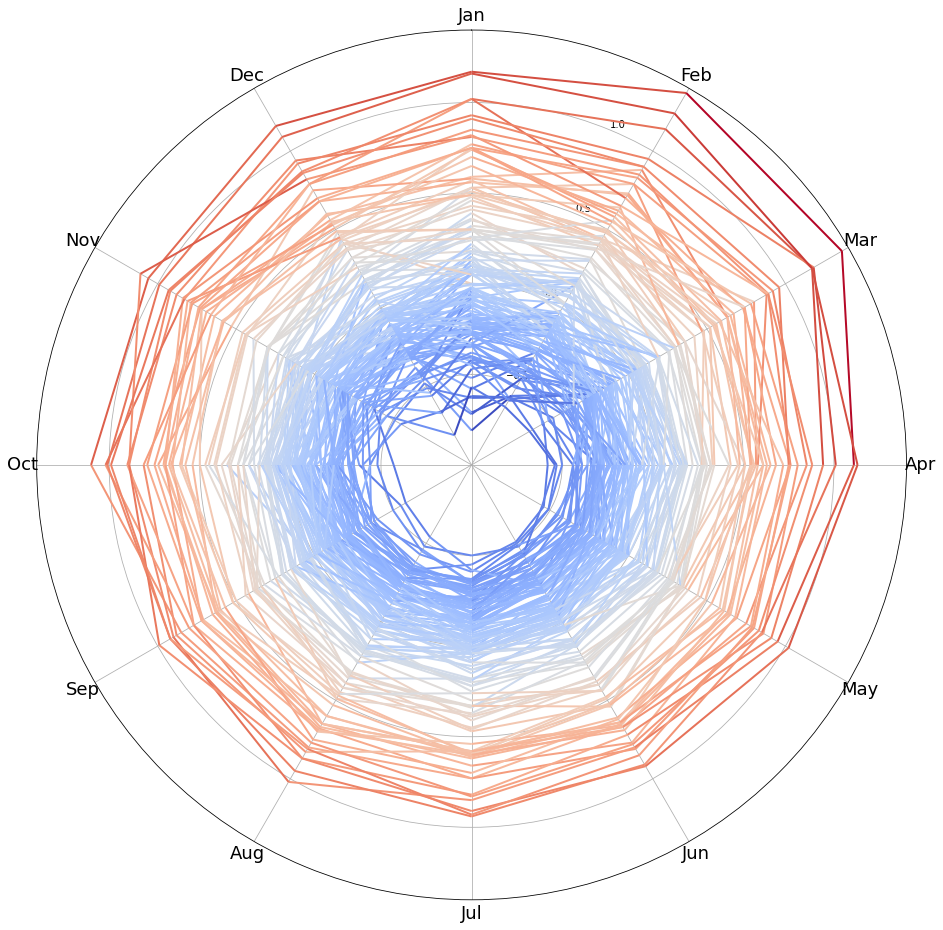

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

# Make the plot clockwise
ax.set_theta_direction(-1)

# With the zero (Jan) on top
ax.set_theta_zero_location('N')

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(data_long.Temp.min(), data_long.Temp.max())
lc = LineCollection(segments, cmap=plt.cm.coolwarm, norm=norm)

# Set the values used for colormapping
lc.set_array(data_long.Temp)
lc.set_linewidth(2)
line = ax.add_collection(lc)

ax.set_ylim(-1, 1.4)
ax.set_xticks(np.arange(12)/12*2*np.pi)
ax.set_xticklabels(labels, fontsize=18);

The original figure doesn't include a colorbar, but it is always good to include one to make clear what each color corresponds to

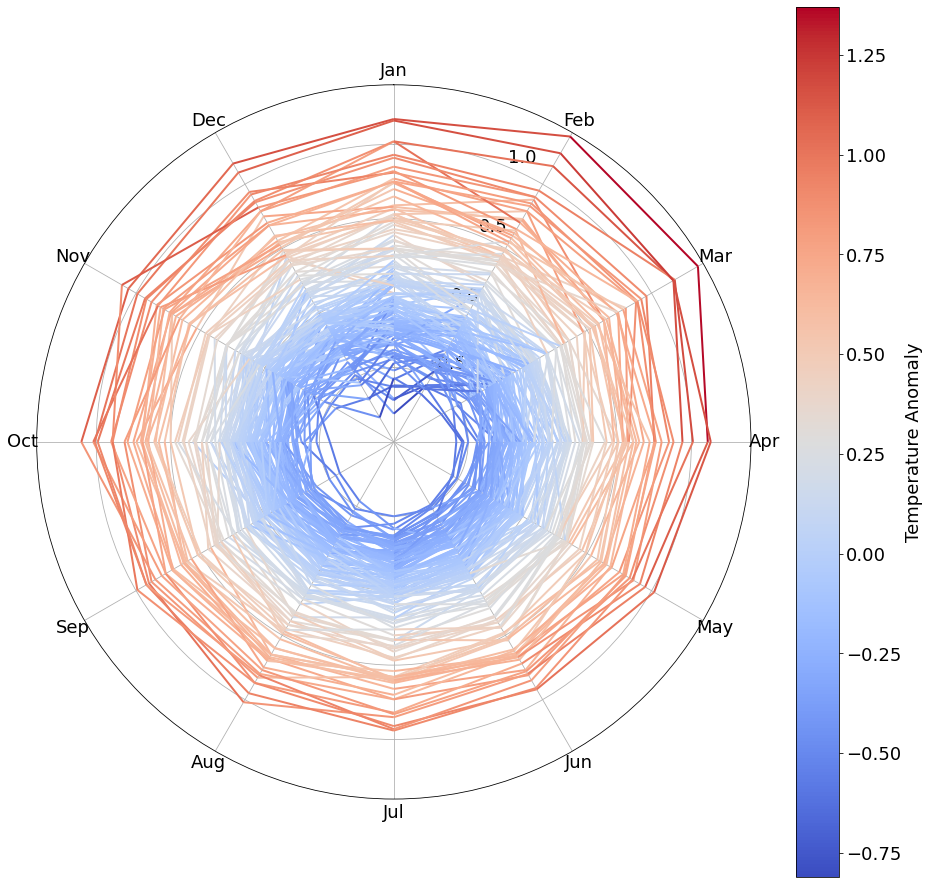

In [13]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

# Make the plot clockwise
ax.set_theta_direction(-1)

# With the zero (Jan) on top
ax.set_theta_zero_location('N')

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(data_long.Temp.min(), data_long.Temp.max())
lc = LineCollection(segments, cmap=plt.cm.coolwarm, norm=norm)

# Set the values used for colormapping
lc.set_array(data_long.Temp)
lc.set_linewidth(2)
line = ax.add_collection(lc)

ax.set_ylim(-1, 1.4)
ax.set_xticks(np.arange(12)/12*2*np.pi)
ax.set_xticklabels(labels, fontsize=18)

# Generate the color bar
cb = fig.colorbar(line, ax=ax)
cb.set_label('Temperature Anomaly', size=18)
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), size=18)
plt.setp(plt.getp(ax.axes, 'yticklabels'), size=18, zorder=3);

Adjust the color scheme to make it closer to the original. We have to modify the background and font colors for both the main image and the colorbar

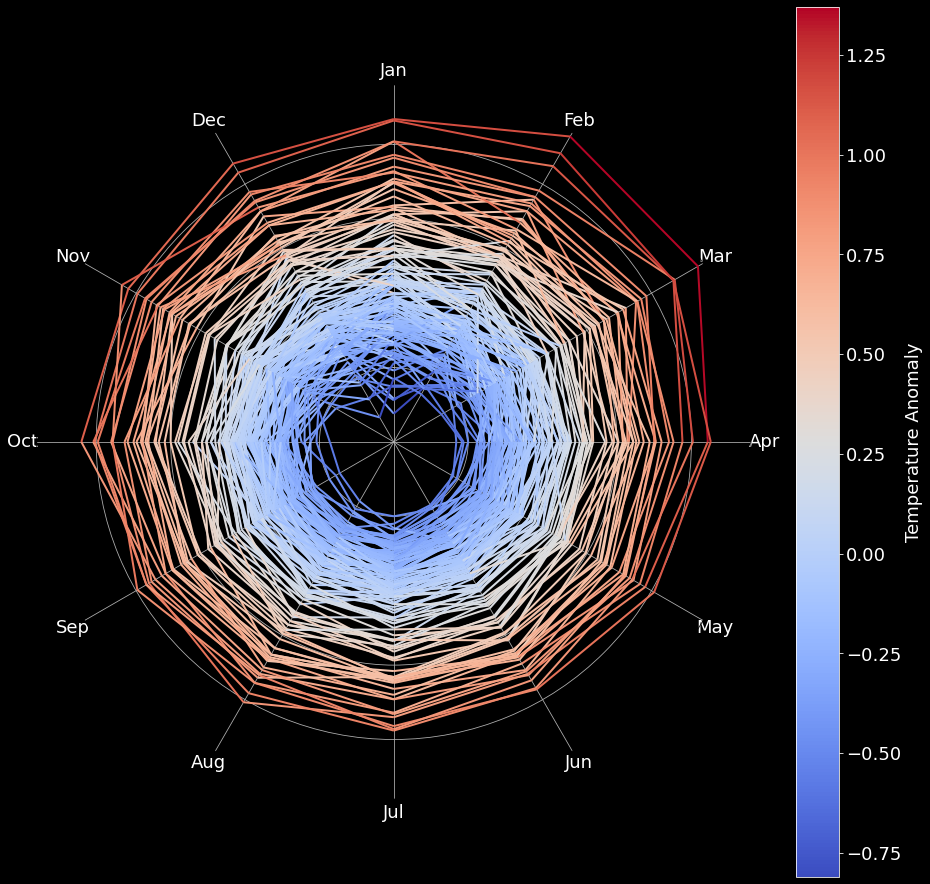

In [14]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

# Make the plot clockwise
ax.set_theta_direction(-1)

# With the zero (Jan) on top
ax.set_theta_zero_location('N')

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(data_long.Temp.min(), data_long.Temp.max())
lc = LineCollection(segments, cmap=plt.cm.coolwarm, norm=norm)

# Set the values used for colormapping
lc.set_array(data_long.Temp)
lc.set_linewidth(2)
line = ax.add_collection(lc)

ax.set_ylim(-1, 1.4)
ax.set_xticks(np.arange(12)/12*2*np.pi)
ax.set_xticklabels(labels, color='white', fontsize=18)

# Generate the color bar
cb = fig.colorbar(line, ax=ax)
cb.set_label('Temperature Anomaly', color='white', size=18)
cb.ax.yaxis.set_tick_params(color='white')
cb.outline.set_edgecolor('white')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=r'white')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), size=18)

# Make the background black
fig.patch.set_facecolor('black')
ax.patch.set_facecolor('black')

# Animation

Now we animate the figure. This is mostly just a reshuffling of the original figure code, with the addition of a simple function to draw each individual frame and an animation object to render each frame in turn and write out the movie file

100%|██████████| 1715/1715 [06:57<00:00,  2.79it/s]

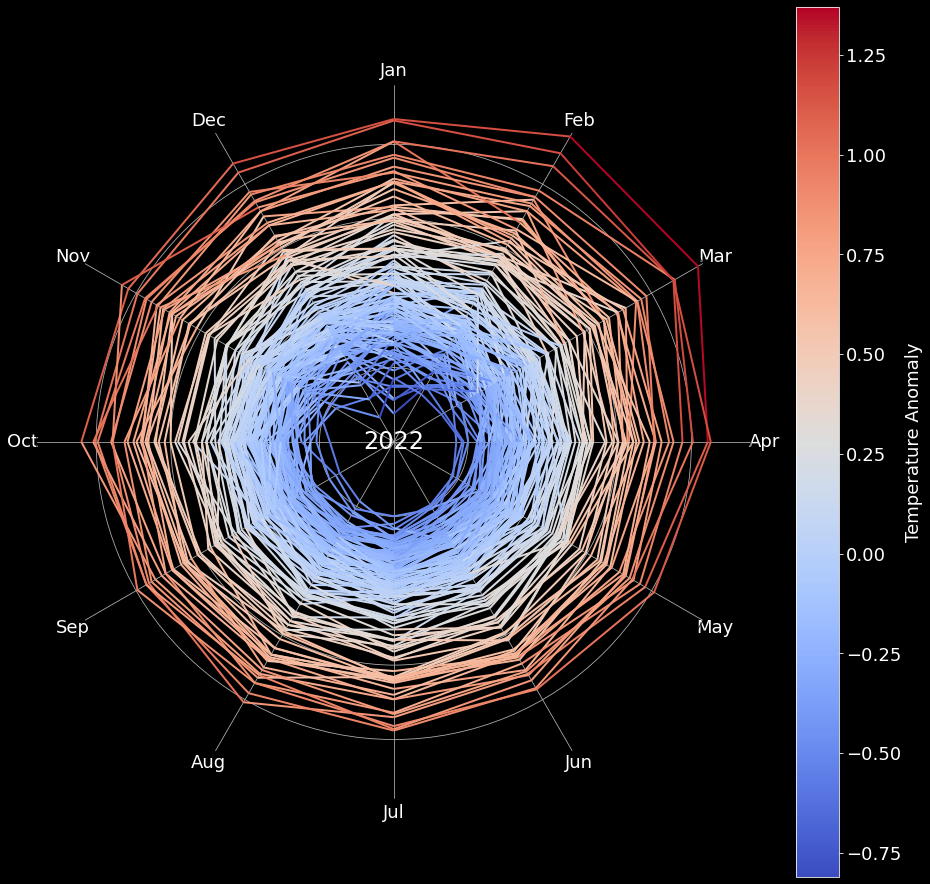

In [15]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

# Make the plot clockwise
ax.set_theta_direction(-1)

# With the zero (Jan) on top
ax.set_theta_zero_location('N')

ax.set_ylim(-1, 1.4)
ax.set_xticks(np.arange(12)/12*2*np.pi)
ax.set_xticklabels(labels, color='white', fontsize=18)

# Set the year label placeholder
label = ax.text(0, -1, data_long.index[0].year, 
            ha='center', va='center', size=24, color='white')

# Generate the color bar
cb = fig.colorbar(line, ax=ax)
cb.set_label('Temperature Anomaly', color='white', size=18)
cb.ax.yaxis.set_tick_params(color='white')
cb.outline.set_edgecolor('white')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=r'white', size=18)

# Make the background black
fig.patch.set_facecolor('black')
ax.patch.set_facecolor('black')

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(data_long.Temp.min(), data_long.Temp.max())
lines = []
lc = LineCollection(lines, cmap=plt.cm.coolwarm, norm=norm)
ax.add_collection(lc)

# The number of data points we have
Nmonths = segments.shape[0]

bar = tqdm(total=Nmonths)

# Define the function that will generate each frame
def animate(count):
    bar.update()
    lc.set_segments(segments[:count])

    # Set the values used for colormapping
    lc.set_array(data_long.Temp.iloc[:count])
    lc.set_linewidth(2)    
    
    # Update the year label
    label.set_text(data_long.index[count].year)
    
    return (lc, label)

# Create the animation object
anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(1, Nmonths, 1), 
                               interval=1, blit=False, repeat=False)

# One second per year
writer = animation.writers['ffmpeg'](fps=12)

# Save the file
anim.save('NASA.mp4', writer=writer)

<div style="width: 100%; overflow: hidden;">
     <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>